In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

* Ulilé Indeque
* William Gabriel da Paz Rozendo

> ### Questão 1

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
def show_imgs(imgs, nrows=1, ncols=4):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 8))
    for ax, img in zip(axes.flat, imgs):
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.axis('off')

In [ ]:
def simulate_mode_dlsr(img_left, img_right):
    stores = []

    row, col = img_left.shape[:2]
    img_left = cv.resize(img_left, (row, col))
    img_right = cv.resize(img_right, (row, col))

    gray_left = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
    gray_right = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)

    stereo = cv.StereoBM_create(numDisparities=16, blockSize=21)
    disparity = stereo.compute(gray_left, gray_right)
    disparity = cv.medianBlur(disparity, 5)

    threshold = 100
    foreground_mask = 255 * (disparity < threshold).astype(np.uint8)

    kernel_size = (25, 25)
    blurred_background = cv.GaussianBlur(img_right, kernel_size, 0)

    foreground = cv.bitwise_and(img_left, img_right, mask=~foreground_mask)
    blurred_background = cv.bitwise_and(blurred_background, blurred_background, mask=foreground_mask)

    dlsr = cv.add(foreground, blurred_background)

    stores.append(img_left)
    stores.append(blurred_background)
    stores.append(foreground)
    stores.append(dlsr)

    return stores

In [ ]:
path0 = "/content/drive/MyDrive/Colab Notebooks/assets4/act4"

In [ ]:
path_img1 = [f"{path0}/teddy/im0.ppm", f"{path0}/teddy/im1.ppm",
             f"{path0}/poster/im0.ppm", f"{path0}/poster/im2.ppm",
             f"{path0}/sawt/im0.ppm", f"{path0}/sawt/im3.ppm"]
imgs1 = list(map(lambda path: cv.imread(path), path_img1))

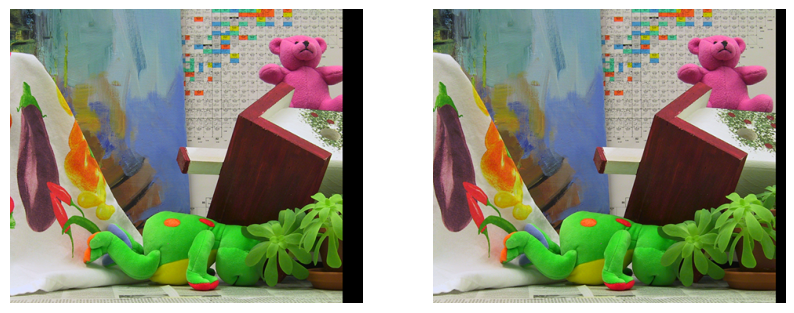

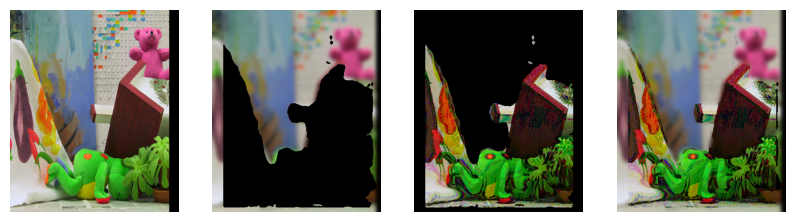

In [ ]:
show_imgs([imgs1[0], imgs1[1]], ncols=2)
stores = simulate_mode_dlsr(imgs1[0], imgs1[1])
show_imgs(stores)

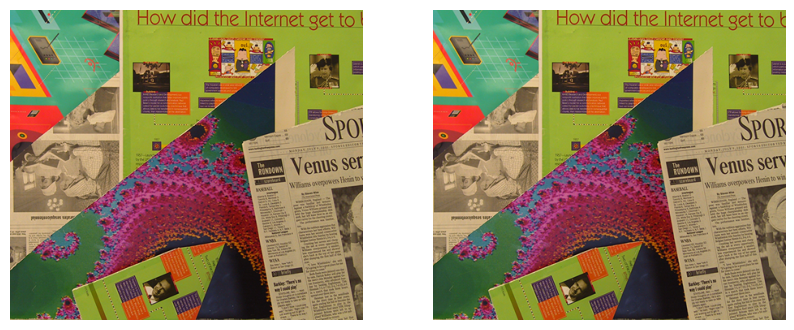

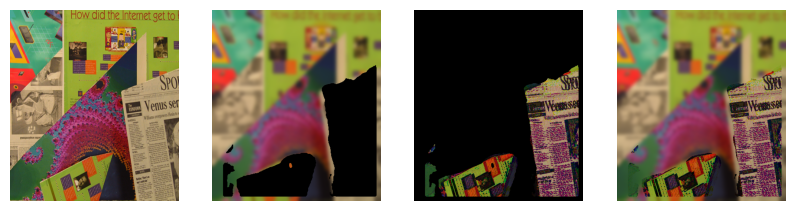

In [ ]:
show_imgs([imgs1[2], imgs1[3]], ncols=2)
stores = simulate_mode_dlsr(imgs1[2], imgs1[3])
show_imgs(stores)

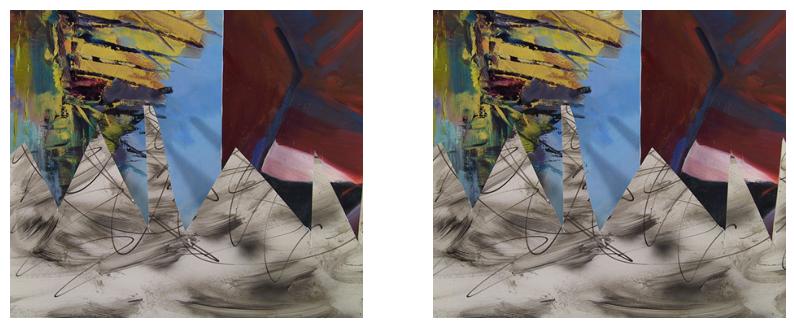

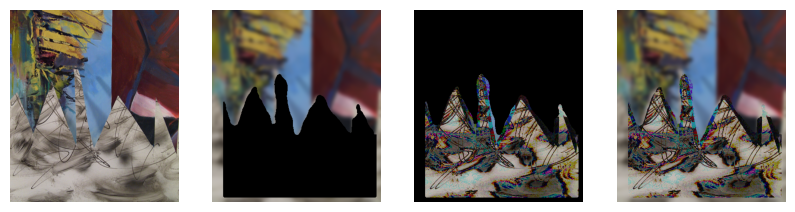

In [ ]:
show_imgs([imgs1[4], imgs1[5]], ncols=2)
stores = simulate_mode_dlsr(imgs1[4], imgs1[5])
show_imgs(stores)

> ## Questão 2

In [ ]:
def show_img_gray(img):
    plt.imshow(img, cmap="gray")
    plt.axis("off")
def show_img_cv(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_RGB2BGR))
    plt.axis("off")

In [ ]:
class Reconstruct3D:
    def __init__(self, path_calib):
        self.path_calib = path_calib
        self.calib_matrix_1 = None
        self.calib_matrix_2 = None
        self.mask = None
        self.idx = None
        self.img = None
        self.left_img = None
        self.right_img = None

    def read_images(self, left, right):

        self.left_img, self.right_img = left, right
        left_imgbw = cv.blur(cv.cvtColor(self.left_img, cv.COLOR_RGB2GRAY), (5, 5))
        right_imgbw = cv.blur(cv.cvtColor(self.right_img, cv.COLOR_RGB2GRAY), (5, 5))
        self.img = left
        return left_imgbw, right_imgbw,

    def show_image(self, img):
        plt.imshow(cv.cvtColor(img, cv.COLOR_RGB2BGR))
        plt.show()

    def write_ply(self, fn, verts, colors):
        ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
        out_colors = colors.copy()
        verts = verts.reshape(-1, 3)
        verts = np.hstack([verts, out_colors])
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

    def compute_disparity(self, left_imgbw, right_imgbw):
        stereo = cv.StereoBM_create(numDisparities=96, blockSize=11)
        disparity = stereo.compute(left_imgbw, right_imgbw)
        return disparity

    def read_calibration(self, matrix_type_1='P2', matrix_type_2='P3'):
        idx_num = 1
        cat_idx = 2
        cat = ['uu', 'uum', 'um']
        IDX_LEN = 6
        fname = cat[cat_idx]+'_'+str(idx_num).zfill(IDX_LEN)
        calib_fname = fname + '.txt'
        calib_file = self.path_calib + calib_fname
        with open(calib_file, 'r') as f:
            fin = f.readlines()
            for line in fin:
                if line[:2] == matrix_type_1:
                    self.calib_matrix_1 = np.array(line[4:]
                                                   .strip()
                                                   .split(" ")).astype('float32').reshape(3,-1)
                elif line[:2] == matrix_type_2:
                    self.calib_matrix_2 = np.array(line[4:]
                                                   .strip()
                                                   .split(" ")).astype('float32').reshape(3,-1)
        return self.calib_matrix_1, self.calib_matrix_2

    def compute_reverse_projection_matrix(self):
        if self.calib_matrix_1 is None or self.calib_matrix_2 is None:
            raise ValueError("Calibration matrices are not set.")

        Tmat = np.array([0.54, 0., 0.])
        cam1 = self.calib_matrix_1[:, :3]  # left image - P2
        cam2 = self.calib_matrix_2[:, :3]  # right image - P3

        rev_proj_matrix = np.zeros((4, 4))

        cv.stereoRectify(cameraMatrix1=cam1, cameraMatrix2=cam2,
                          distCoeffs1=0, distCoeffs2=0,
                          imageSize=(640, 480),
                          R=np.identity(3), T=Tmat,
                          R1=None, R2=None,
                          P1=None, P2=None, Q=rev_proj_matrix)

        return rev_proj_matrix

    def process_points_colors(self, img, rev_proj_matrix):
        points = cv.reprojectImageTo3D(img, rev_proj_matrix)

        # reflect on x axis
        reflect_matrix = np.identity(3)
        reflect_matrix[0] *= -1
        points = np.matmul(points, reflect_matrix)

        # extract colors from image
        colors = cv.cvtColor(self.left_img, cv.COLOR_BGR2RGB)

        # filter by min disparity
        self.mask = img > img.min()
        out_points = points[self.mask]
        out_colors = colors[self.mask]

        # filter by dimension
        self.idx = np.fabs(out_points[:, 0]) < 4.5
        out_points = out_points[self.idx]
        out_colors = out_colors.reshape(-1, 3)
        out_colors = out_colors[self.idx]

        self.write_ply('out.ply', out_points, out_colors)
        print('%s saved' % 'out.ply')
        return out_points, reflect_matrix

    def project_to_image(self, out_points, reflect_matrix, calib_matrix):

        reflected_pts = np.matmul(out_points, reflect_matrix)
        projected_img, _ = cv.projectPoints(reflected_pts, np.identity(3),
                                            np.array([0., 0., 0.]),
                                            calib_matrix[:3, :3],
                                            np.array([0., 0., 0., 0.]))
        projected_img = projected_img.reshape(-1, 2)
        return projected_img

    def draw_circles_on_image(self, projected_img):
        blank_img = np.zeros(self.left_img.shape, 'uint8')
        img_colors = self.right_img[self.mask][self.idx].reshape(-1,3)


        for i, pt in enumerate(projected_img):
            pt_x = int(pt[0])
            pt_y = int(pt[1])
            if pt_x > 0 and pt_y > 0:
                col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
                cv.circle(blank_img, (pt_x, pt_y), 1, col)

        return blank_img

In [ ]:
def run(path_cal, left, right):
    path_calib = path_cal
    obj3D = Reconstruct3D(path_calib)

    left_bw, right_bw = obj3D.read_images(left, right)

    disparity = obj3D.compute_disparity(left_bw, right_bw)
    calib_matrix_1, calib_matrix_2 = obj3D.read_calibration()

    rev_proj_matrix = obj3D.compute_reverse_projection_matrix()

    out_points, reflect_matrix = obj3D.process_points_colors(disparity.copy(), rev_proj_matrix)
    projected_img = obj3D.project_to_image(out_points, reflect_matrix, calib_matrix_2)
    blanck_img = obj3D.draw_circles_on_image(projected_img)
    return blanck_img

In [ ]:
path_cal = "/content/drive/MyDrive/Colab Notebooks/assets4/act4/"

<ipython-input-10-19aab964a568>:94: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflect_matrix)


out.ply saved


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
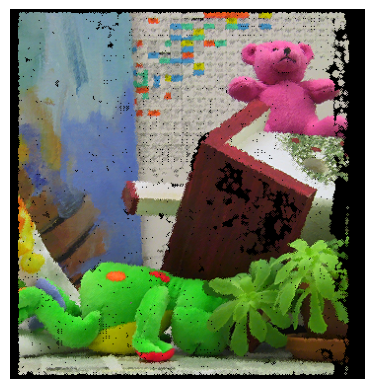

In [ ]:
left, right = imgs1[0], imgs1[1]
b = run(path_cal, left, right)
show_img_cv(b)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
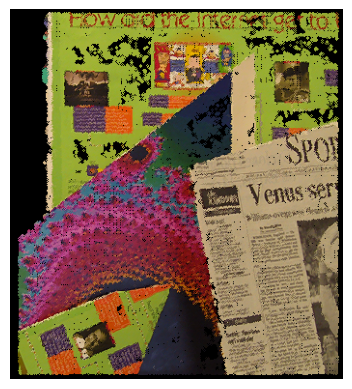

In [ ]:
left, right = imgs1[2], imgs1[3]
b = run(path_cal, left, right)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
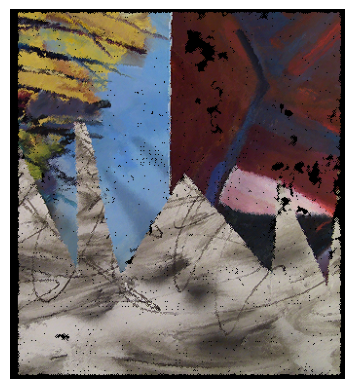

In [ ]:
left, right = imgs1[4], imgs1[5]
b = run(path_cal, left, right)

b) Etapas executada

* Inicialmente, foi feita a leitura das imagens e convesão para escala grey.
* O segundo passo é aplicação da computação da disparidade para obter mapa de disparidade entre imagens da esquerda e direita atraves  
do objeto stereo = cv.StereoBM_create(numDisparities=96, blockSize=11) e disparity = stereo.compute(img_left_bw,img_right_bw).
Os parâmetros numDisparities e blockSize servem para definir o numero máximo de disparidade a ser considera e o tamanho da janela
a ser usado na computação.
* A terceira etapa calibração a partir da matriz de calibração lida.
    calib_file = data_folder_calib + calib_fname
    """with open(calib_file, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:2] == matrix_type_1:
                calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:2] == matrix_type_2:
                calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)"""

    a matriz de calibração tem a equção [fx 0 cx; 0 fy 0; 0 0 1] com distâncias focais (fx, fy) e coordenadas (cx, cy).
* A quarta etapa é a computação da profundidade. Isso é feito transformando mapa de disparidade, utilizando a funçao stereoRectify() e
    passando como parametros matrix da camera esquerda e direita e matriz de translação deslocado 0.54 em x. Com isso obtem-se a matriz com os pontos.
* Essa etapa é apenas para correção dos pontos corresponde na imagem e filtragem "#filter by min disparity mask = img > img.min() out_points = points[mask] out_colors = colors[mask] ..."
* Depois disso, aplicação da função write_ply para salvar nuvens de pontos gerados anterior para visualização (meshlab).
* No final, foi feita a projecão dos pontos e visualização onde cada pixel é desenhado como circulo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> ## Questão 3

In [ ]:
import os
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
path1 = '/content/drive/MyDrive/Colab Notebooks/assets4/act4/test_set/test_set'
path2 = '/content/drive/MyDrive/Colab Notebooks/assets4/act4/training_set/training_set'

In [ ]:
import os
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train = train_datagen.flow_from_directory(path2,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 shuffle=True,
                                                 class_mode = 'binary')

Found 8009 images belonging to 2 classes.


In [ ]:
num = 8005
all_train = []
all_target = []
for i in range(num // 32):
    batch_images, batch_labels = train.next()
    all_train.extend(batch_images)
    all_target.extend(batch_labels)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
valid = next(test_datagen.flow_from_directory(path1,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary'))

Found 2024 images belonging to 2 classes.


In [ ]:
num = 2023
all_valid = []
all_val_y = []
for i in range(num // 32):
    batch_images, batch_labels = train.next()
    all_valid.extend(batch_images)
    all_val_y.extend(batch_labels)

In [ ]:
all_train, all_target = np.array(all_train), np.array(all_target)
all_valid, all_val_y  = np.array(all_valid), np.array(all_val_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_train, all_target, test_size=0.3, random_state=42)

In [ ]:
import cv2 as cv

> #### usando svm

In [ ]:
winSize = (64, 64)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

In [ ]:
def extract_hog_features(images):
    features = []
    for image in images:
        features.append(hog.compute(image.astype(np.uint8)))
    return np.array(features)

train_hog = extract_hog_features(all_train)

In [ ]:
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(
    train_hog, all_target, test_size=0.3, random_state=42)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC()
svm.fit(X_train_hog, y_train_hog)

SVC()

In [ ]:
y_hat_svm = svm.predict(X_test_hog)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test_hog, y_hat_svm))

              precision    recall  f1-score   support

         0.0       0.51      0.89      0.65      1172
         1.0       0.64      0.18      0.28      1222

    accuracy                           0.53      2394
   macro avg       0.57      0.54      0.46      2394
weighted avg       0.57      0.53      0.46      2394



> #### usando cnn

> #### usando vgg

In [ ]:
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.models import Model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs=base_model.input, outputs=output)
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

Epoch 1/5
175/175 [==============================] - 293s 2s/step - loss: 0.5458 - accuracy: 0.7242
Epoch 2/5
175/175 [==============================] - 284s 2s/step - loss: 0.4594 - accuracy: 0.7838
Epoch 3/5
175/175 [==============================] - 282s 2s/step - loss: 0.4303 - accuracy: 0.8012
Epoch 4/5
175/175 [==============================] - 281s 2s/step - loss: 0.4073 - accuracy: 0.8171
Epoch 5/5
175/175 [==============================] - 283s 2s/step - loss: 0.3908 - accuracy: 0.8211


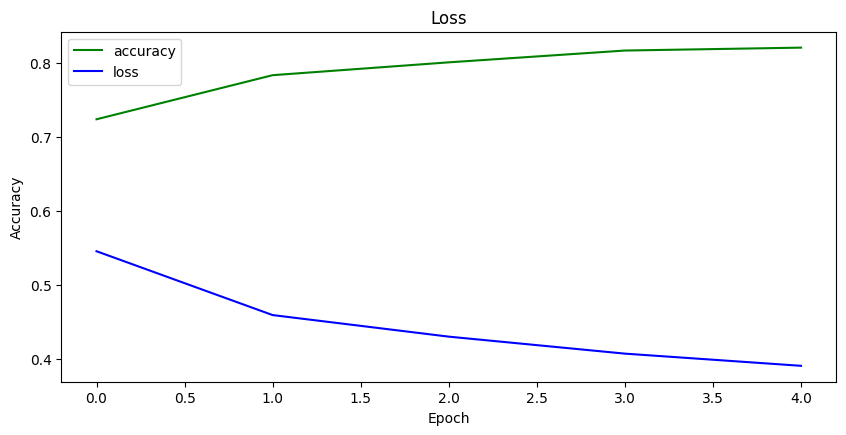

In [ ]:
def plot_model_summary_trans(histories):
      plt.figure(figsize=(10, 10))
      plt.subplot(2, 1, 1)
      plt.title('Loss')
      plt.plot(histories.history['accuracy'], color='green', label='accuracy')
      plt.plot(histories.history['loss'], color='blue', label='loss')
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.legend()
      plt.show()

vgg_histories = vgg_model.fit(X_train, y_train, epochs=5, batch_size=32)
plot_model_summary_trans(vgg_histories)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

> #### avaliação do vgg

In [ ]:
loss_vgg, acc_vgg = vgg_model.evaluate(X_test, y_test)

75/75 [==============================] - 120s 2s/step - loss: 0.4328 - accuracy: 0.7974


75/75 [==============================] - 122s 2s/step


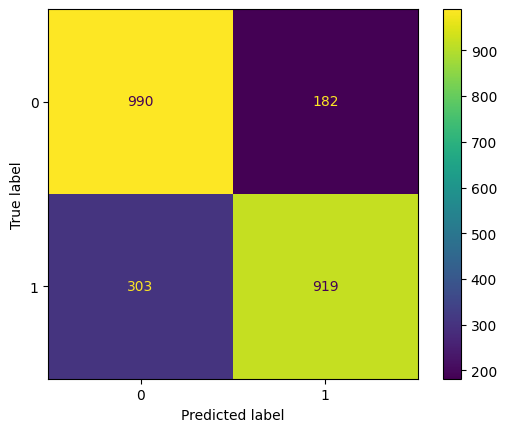

In [ ]:
y_hat_vgg = vgg_model.predict(X_test)
y_hat_vgg = np.where(np.array(y_hat_vgg) < 0.5, 0, 1)
cm = confusion_matrix(y_test, y_hat_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

> ### Resnet50

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
res_model = Model(inputs=base_model.input, outputs=output)
res_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy'])
res_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                       

In [ ]:
res_histories = res_model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
175/175 [==============================] - 94s 505ms/step - loss: 0.6965 - accuracy: 0.5182
Epoch 2/10
175/175 [==============================] - 89s 507ms/step - loss: 0.6866 - accuracy: 0.5372
Epoch 3/10
175/175 [==============================] - 90s 516ms/step - loss: 0.6790 - accuracy: 0.5776
Epoch 4/10
175/175 [==============================] - 86s 491ms/step - loss: 0.6756 - accuracy: 0.5932
Epoch 5/10
175/175 [==============================] - 88s 501ms/step - loss: 0.6705 - accuracy: 0.6027
Epoch 6/10
175/175 [==============================] - 86s 491ms/step - loss: 0.6677 - accuracy: 0.5963
Epoch 7/10
175/175 [==============================] - 87s 500ms/step - loss: 0.6660 - accuracy: 0.5959
Epoch 8/10
175/175 [==============================] - 86s 491ms/step - loss: 0.6632 - accuracy: 0.6058
Epoch 9/10
175/175 [==============================] - 86s 491ms/step - loss: 0.6596 - accuracy: 0.6147
Epoch 10/10
175/175 [==============================] - 88s 503ms/step - l

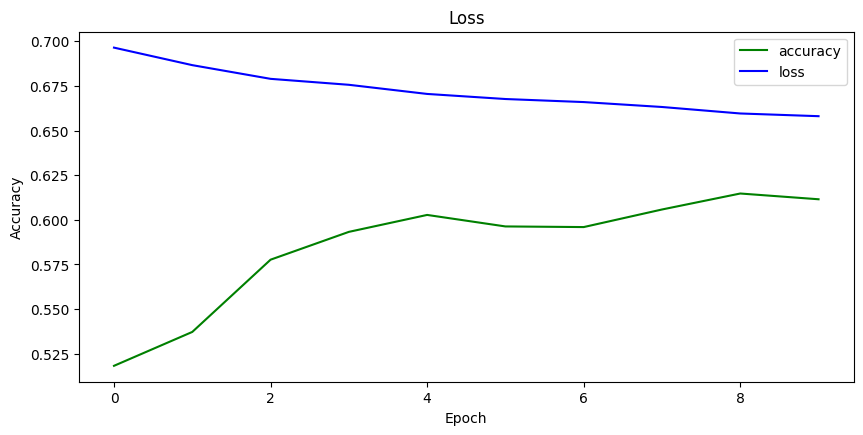

In [ ]:
plot_model_summary_trans(res_histories)

avaliação do resnet50

In [ ]:
loss_res, acc_res = res_model.evaluate(X_test, y_test)

75/75 [==============================] - 37s 490ms/step - loss: 0.6478 - accuracy: 0.6387


75/75 [==============================] - 38s 507ms/step


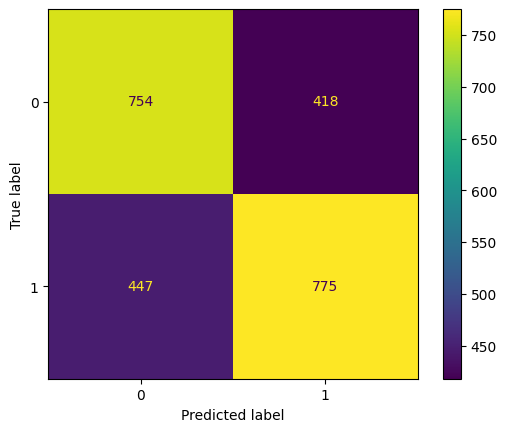

In [ ]:
y_hat_res = res_model.predict(X_test)
y_hat_res = np.where(np.array(y_hat_res) < 0.5, 0, 1)
cm = confusion_matrix(y_test, y_hat_res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

> ### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
mob_model = Model(inputs=base_model.input, outputs=output)
mob_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
mob_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

In [ ]:
mob_histories = mob_model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
175/175 [==============================] - 22s 92ms/step - loss: 0.5303 - accuracy: 0.7227
Epoch 2/10
175/175 [==============================] - 16s 90ms/step - loss: 0.4180 - accuracy: 0.8006
Epoch 3/10
175/175 [==============================] - 17s 95ms/step - loss: 0.3628 - accuracy: 0.8413
Epoch 4/10
175/175 [==============================] - 17s 94ms/step - loss: 0.3226 - accuracy: 0.8667
Epoch 5/10
175/175 [==============================] - 16s 90ms/step - loss: 0.2898 - accuracy: 0.8843
Epoch 6/10
175/175 [==============================] - 16s 90ms/step - loss: 0.2633 - accuracy: 0.9018
Epoch 7/10
175/175 [==============================] - 16s 91ms/step - loss: 0.2359 - accuracy: 0.9205
Epoch 8/10
175/175 [==============================] - 19s 108ms/step - loss: 0.2140 - accuracy: 0.9312
Epoch 9/10
175/175 [==============================] - 25s 144ms/step - loss: 0.1935 - accuracy: 0.9466
Epoch 10/10
175/175 [==============================] - 31s 176ms/step - loss: 0.

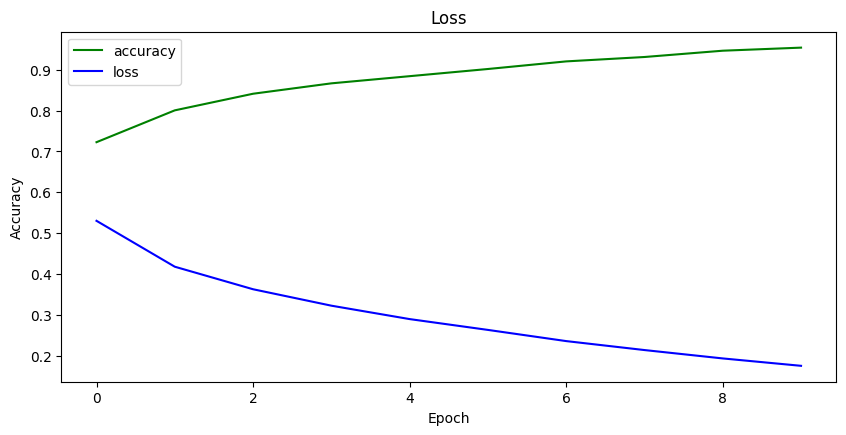

In [ ]:
plot_model_summary_trans(mob_histories)

> #### avaliação mobilenet

In [ ]:
loss_res, acc_res = mob_model.evaluate(X_test, y_test)

75/75 [==============================] - 9s 103ms/step - loss: 0.4540 - accuracy: 0.7870


75/75 [==============================] - 9s 103ms/step


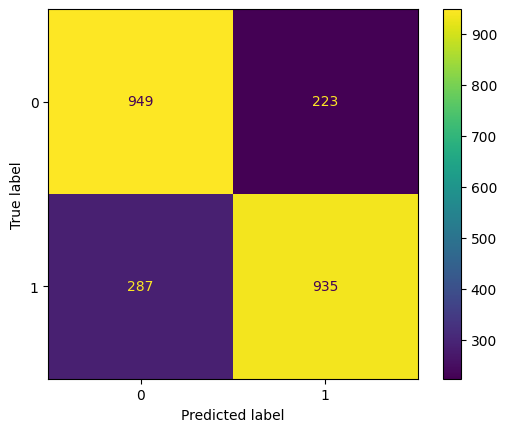

In [ ]:
y_hat_mob = mob_model.predict(X_test)
y_hat_mob = np.where(np.array(y_hat_mob) < 0.5, 0, 1)
cm = confusion_matrix(y_test, y_hat_mob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Questão 4

> ## usando yolo

a)
O SSD é baseado em uma arquitetura de rede neural convolucional (CNN) que combina diferentes camadas convolucionais para detecção de objetos em diferentes escalas. SSD usa uma série de camadas convolucionais de diferentes tamanhos para gerar múltiplos mapas de características que são usados para prever caixas delimitadoras e classes de objetos. Por outro lado, YOLO adota uma abordagem diferente, onde o backbone da rede neural (muitas vezes a CNN pré-treinada) é seguido por uma "Pirâmide de Características", que consiste em várias camadas convolucionais e é responsável por capturar informações em diferentes escalas. Isso permite que a YOLO faça detecções em várias resoluções espaciais simultaneamente. Em termos de eficiência, o YOLO pode ser mais eficiênte por utilizar uma passagem para previsão varias escalas.

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.3/107.7 GB disk)


In [ ]:
from ultralytics import YOLO
import cv2 as cv
import matplotlib.pyplot as plt

In [ ]:
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 168MB/s]


In [ ]:
path = "bridge.mp4"

In [ ]:
!yolo task=detect mode=predict model=yolov8x.pt conf=0.2 source={path}

Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

video 1/1 (frame 1/576) /content/bridge.mp4: 384x640 3 persons, 21 cars, 1 bus, 5 traffic lights, 2796.9ms
video 1/1 (frame 2/576) /content/bridge.mp4: 384x640 3 persons, 21 cars, 1 bus, 5 traffic lights, 3115.2ms
video 1/1 (frame 3/576) /content/bridge.mp4: 384x640 2 persons, 20 cars, 2 buss, 7 traffic lights, 2467.4ms
video 1/1 (frame 4/576) /content/bridge.mp4: 384x640 3 persons, 19 cars, 2 buss, 7 traffic lights, 2358.4ms
video 1/1 (frame 5/576) /content/bridge.mp4: 384x640 3 persons, 19 cars, 1 bus, 8 traffic lights, 2445.1ms
video 1/1 (frame 6/576) /content/bridge.mp4: 384x640 3 persons, 17 cars, 2 buss, 8 traffic lights, 3225.5ms
video 1/1 (frame 7/576) /content/bridge.mp4: 384x640 4 persons, 18 cars, 2 buss, 8 traffic lights, 2462.2ms
video 1/1 (frame 8/576) /content/bridge.mp4: 384x640 4 persons, 18 cars, 1 air

Videoa de carros: https://drive.google.com/file/d/1biYs9GXi6Ju35-5GDM8J-OeDR6Tb3uAG/view?usp=sharing

> ## usando ssd

In [ ]:
!git clone https://github.com/tensorflow/models.git
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.
!cd models/research && \
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install  .

  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.15.1
    Uninstalling tf_keras-2.15.1:
      Successfully uninstalled tf_keras-2.15.1


In [ ]:
import imageio
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

In [ ]:
model = tf.keras.utils.get_file(
    fname='ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
    origin='http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz',
    untar=True)

In [ ]:
labels = tf.keras.utils.get_file(
    fname='mscoco_label_map.pbtxt',
    origin='https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt',
    untar=False)

In [ ]:
detector = tf.saved_model.load(model + '/saved_model')

cat = label_map_util.create_category_index_from_labelmap(
    labels,
    use_display_name=True
)

In [ ]:
def detect_objects_in_frame(image):
    input_tensor = tf.convert_to_tensor(image)

    input_tensor = input_tensor[tf.newaxis, ...]

    detected = detector(input_tensor)

    num_detections = int(detected.pop('num_detections'))
    detected = {key: value[0, :num_detections].numpy()
                   for key, value in detected.items()}
    detected['num_detections'] = num_detections

    detected['classes'] = detected['classes'].astype(np.int64)

    image_with_detections = image.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_with_detections,
          detected['boxes'],
          detected['classes'],
          detected['scores'],
          cat,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)
    return image_with_detections, detected['classes']

In [ ]:
def detector(input_video):
    frames = []
    n_detects = []

    video_reader = imageio.get_reader(path)
    video_writer = imageio.get_writer(path, fps=20)

    n_frames = 0
    for frame in video_reader:
        frames.append(n_frames)
        n_frames += 1
        new_frame, num_detections = detect_objects_in_frame(frame)
        n_detects.append(num_detections)
        video_writer.append_data(new_frame)

    np.save('n_cars.npy', n_detects)
    np.save('n_frames.npy', frames)
    video_writer.close()

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/assets4/act4/bridge.mp4"

In [ ]:
detector(path)

In [ ]:
n_cars = np.load('n_cars.npy')
n_frames = np.load('n_frames.npy')
len(n_cars), len(n_frames)

In [ ]:
detected_byssd = []

for detection_list in n_cars:
    count_category_3 = np.sum(detection_list == 3)
    detected_byssd.append(count_category_3)

b)

#### ssd

In [ ]:
figure = plt.figure(figsize=(10, 8))
plt.plot(n_frames, detected_byssd, color='red')
plt.title('SSD')
plt.xlabel('Frames')
plt.ylabel('Carros')
plt.show()

### yolo

In [ ]:
figure = plt.figure(figsize=(10, 8))
plt.plot(range(0, len(n_cars)), [int(cars) for cars in n_cars], color='blue')
plt.title('YOLO')
plt.xlabel('Frames')
plt.ylabel('Carros')
plt.tight_layout()
plt.show()